In [11]:
########################################
### Function section
########################################
def gameSession(eventList):
    """
    Computes the lengths of game sessions based on a list of events.
    """
    eventList = sorted(eventList, key=lambda x: x['event_timestamp'])
    gameSessionLengthMs = []
    for currentEvent in eventList:
        if currentEvent['event_type'] == 0:
            tsSessionStart = currentEvent['event_timestamp']
        if currentEvent['event_type'] == 1:
            tsSessionEnd = currentEvent['event_timestamp']
            gameSessionLengthMs.append(tsSessionEnd-tsSessionStart)
    return gameSessionLengthMs  

In [12]:
import os
import json
import pandas as pd
import numpy as np

folder_path = './data'
all_game_session_lengths = []

# Recorremos los archivos JSON del directorio
for file_name in os.listdir(folder_path):
    if file_name.startswith('X'):
        continue
    if file_name.endswith('.json'):
        file_path = os.path.join(folder_path, file_name)
        print(f"Procesando archivo: {file_name}")
        with open(file_path, 'r') as file:
            raw_data = json.load(file)
            events = raw_data.get("data", [])

            # Verificamos que sea una lista de diccionarios
            if isinstance(events, list) and all(isinstance(e, dict) for e in events):
                gameSessionLengthMs = gameSession(events)
                all_game_session_lengths.extend(gameSessionLengthMs)
            else:
                print(f"Formato no esperado en: {file_name}")

# Imprimir estadísticas
s = pd.Series(all_game_session_lengths)
print(s.describe())


Procesando archivo: TimeLess_Traza_474dbffe-90c8-45a9-bfea-2ac3fdf39a8d.json
Procesando archivo: TimeLess_Traza_59df472f-4cec-4247-9d96-6dc1b59cb73c.json
Procesando archivo: TimeLess_Traza_aff27b4e-3624-4129-ac28-7227e95aab1b.json
Procesando archivo: TimeLess_Traza_c5b2534a-3ee0-4f9d-abfc-f94f73486b4f.json
count    4.000000e+00
mean     1.391037e+06
std      9.928192e+05
min      5.183540e+05
25%      6.218915e+05
50%      1.212220e+06
75%      1.981366e+06
max      2.621354e+06
dtype: float64


In [13]:
import matplotlib.pyplot as plt
from context_data import RootContextData

def processEventsWithContext(data):
    """
    Processes events using a context stack and computes metrics.

    This function uses a context-based approach to process a list of events. 
    Events are processed sequentially, and the context stack determines how each event is handled.
    """
    sorted_data = sorted(data, key=lambda x: x['event_timestamp'])
    contextStack = []
    currentEventIx = 0
    totalEvents = len(sorted_data)
    contextStack.append(RootContextData(contextStack))

    while currentEventIx < totalEvents:
        currentEvent = sorted_data[currentEventIx]
        if len(contextStack) == 0:
            # If the context stack is empty, stop processing
            break
        else:
            # Use the context at the top of the stack
            currentContext = contextStack[-1]
            # Parse event using the current context
            consumeEvent = currentContext.parseEvent(currentEvent)
            # Some contexts update the stack and leave the event for the next/previous context
            # If the context does not consume the event, we do not increment the index
            if consumeEvent:
                currentEventIx += 1

    # Store all game sessions in a list
    gameSessionLengthMs = [game.gameSessionLengthMs for game in contextStack[-1].games]

    # Store all data in the in a list.
    levels = []
    for game in contextStack[-1].games:
        for level in game.levels:
            levels.append(dict( levelid=level.id, result=level.levelResult, duration=level.levelLengthMs, deaths=level.deaths, gravity=level.gravity, freeze=level.freeze))


    return {
        "gameSessionLengthMs": gameSessionLengthMs,
        "levels": levels
    }

def drawHexbinHeatmap(data_list, background_image, output_file, gridsize=(27, 22), extent=[0, 865, 0, 705]):

    data = pd.DataFrame(data_list)

    fig, ax = plt.subplots(figsize=(27, 22))

    img = plt.imread(background_image)
    ax.imshow(img, extent=extent, origin='upper')

    # Heatmap con hexbin
    hb = ax.hexbin(
        data["x"], data["y"],
        gridsize=gridsize,
        extent=extent,
        cmap='Reds',
        alpha=0.5,
        reduce_C_function=np.sum
    )
    
    cb = fig.colorbar(hb, ax=ax)
    cb.set_label('Cantidad de muertes')

    ax.set_xlim(extent[0], extent[1])
    ax.set_ylim(extent[2], extent[3])

    ax.set_xticks(range(int(extent[0]), int(extent[1]) + 1, 100))
    ax.set_yticks(range(int(extent[2]), int(extent[3]) + 1, 100))

    fig.savefig(output_file)
    print(f"Aggregated heatmap saved as {output_file}")



Processing file: TimeLess_Traza_474dbffe-90c8-45a9-bfea-2ac3fdf39a8d.json
Processing file: TimeLess_Traza_59df472f-4cec-4247-9d96-6dc1b59cb73c.json
Processing file: TimeLess_Traza_aff27b4e-3624-4129-ac28-7227e95aab1b.json
Processing file: TimeLess_Traza_c5b2534a-3ee0-4f9d-abfc-f94f73486b4f.json
Aggregated Game Session Length Statistics:
count    4.000000e+00
mean     1.391037e+06
std      9.928192e+05
min      5.183540e+05
25%      6.218915e+05
50%      1.212220e+06
75%      1.981366e+06
max      2.621354e+06
dtype: float64
Aggregated heatmap saved as graphics/nivel1_deaths_heatmap.png
Aggregated heatmap saved as graphics/nivel2_deaths_heatmap.png
Aggregated heatmap saved as graphics/nivel3_deaths_heatmap.png
Aggregated heatmap saved as graphics/nivel4_deaths_heatmap.png


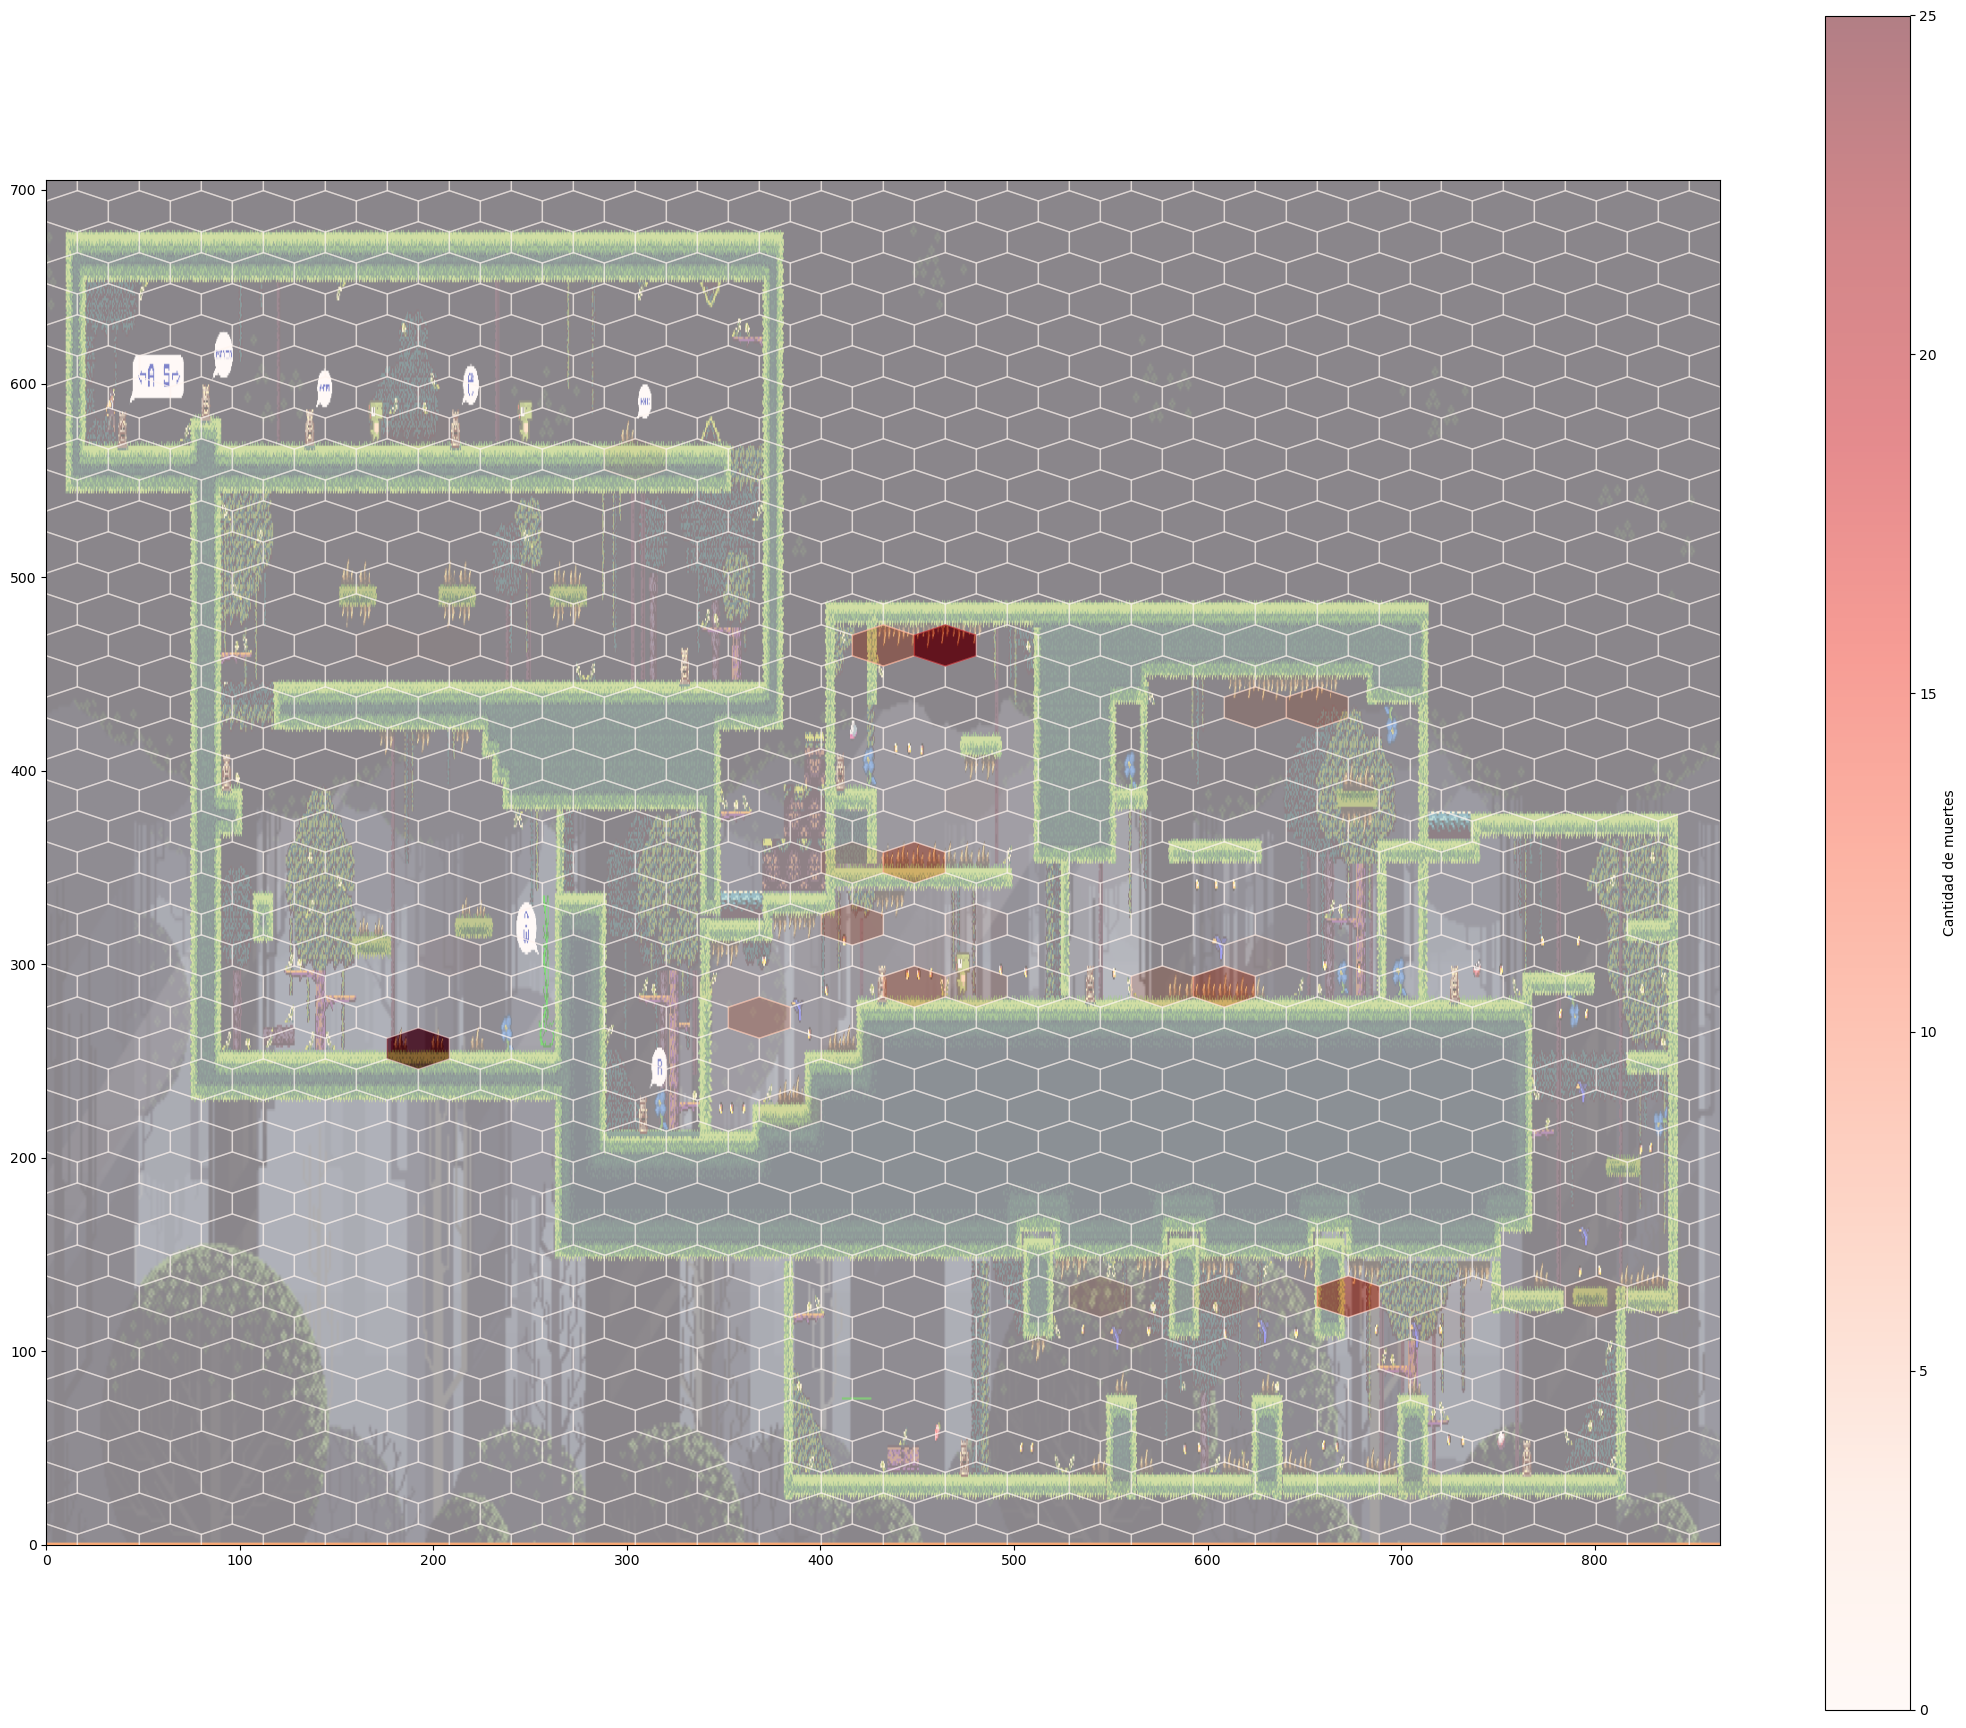

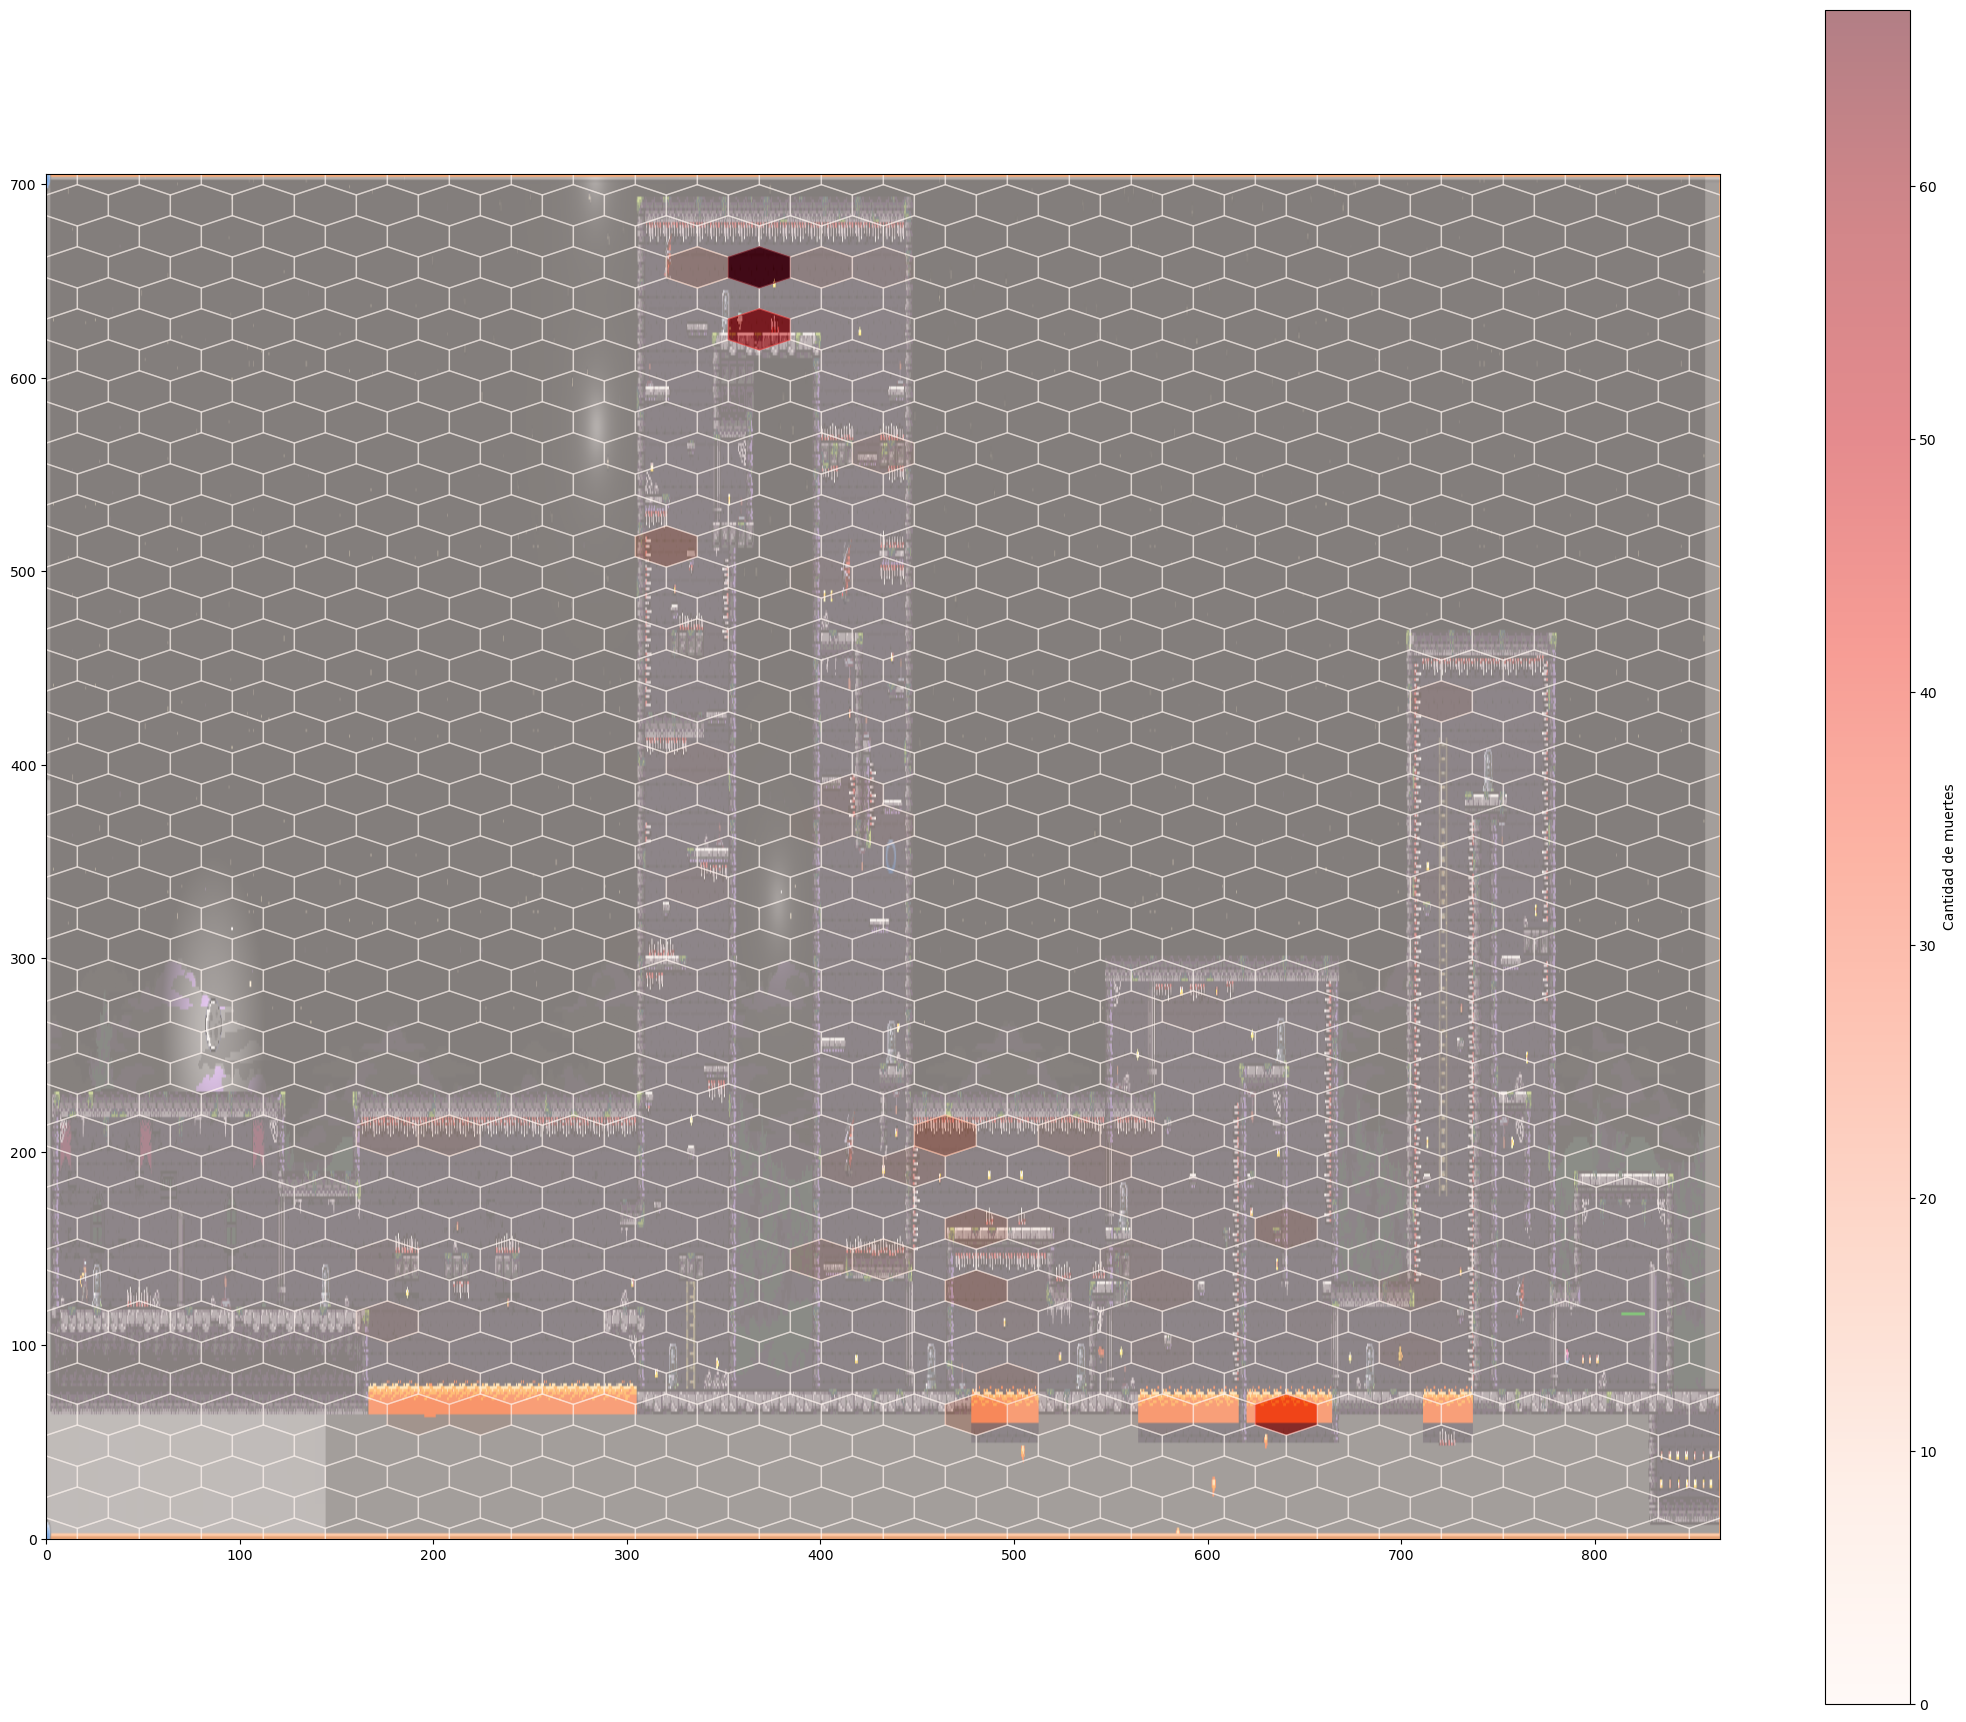

In [14]:
from collections import defaultdict

"""Approach 2 (Advances): Events are streamed so they are procesed sequentially.
Every event is processed depending on the current context (defined by the events that
we have already processed). Contexts are stacked so the event is processed using the top
context. Events can trigger a pop operation on a stack. 

 In this case, we have a context sessions and levels, and a root context that stores the 
games (in this example, we don't have sessions). Each context stores metrics and/or other contexts 
"""
# Initialize lists to aggregate results
all_game_session_lengths = []
all_levels = []

# Iterate over all files in the folder
for file_name in os.listdir(folder_path):
    # Remove corrupted files (manually identified, starting with X)
    if file_name.startswith('X'):
        continue
    if file_name.endswith('.json'):  # Process only JSON files
        file_path = os.path.join(folder_path, file_name)
        print(f"Processing file: {file_name}")

        # Open the JSON file and load its contents
        with open(file_path, 'r') as file:
            json_data = json.load(file)
            events = json_data.get("data", [])

        # Process events using the context-based approach
        results = processEventsWithContext(events)

        # Aggregate results
        all_game_session_lengths.extend(results["gameSessionLengthMs"])
        all_levels.extend(results["levels"])


 # Compute aggregated statistics for game session lengths
s = pd.Series(all_game_session_lengths)
print("Aggregated Game Session Length Statistics:")
print(s.describe())

# Carga la configuración desde JSON de los mapas
with open("mapas/mapas_config.json", "r") as f:
    mapas_config = json.load(f)

# Diccionarios para agrupar por nivel
muertes_por_nivel = defaultdict(list)
gravity_por_nivel = defaultdict(list)
freeze_por_nivel = defaultdict(list)
conteo_por_nivel = defaultdict(int)

# Agrupar eventos por nivelid
for nivel in all_levels:
    nivel_id = nivel['levelid']
    muertes_por_nivel[nivel_id].extend(nivel.get('deaths', []))
    gravity_por_nivel[nivel_id].extend(nivel.get('gravity', []))
    freeze_por_nivel[nivel_id].extend(nivel.get('freeze', []))
    conteo_por_nivel[nivel_id] += 1

# Crear lista final incluyendo todos los datos
resultados_por_nivel = []
for nivel_id in range(1, 5):
    resultados_por_nivel.append({
        "levelid": nivel_id,
        "deaths": muertes_por_nivel.get(nivel_id, []),
        "gravity": gravity_por_nivel.get(nivel_id, []),
        "freeze": freeze_por_nivel.get(nivel_id, [])
    })

ancho_img = 865
altura_img = 705

for nivel_data in resultados_por_nivel:
    nivel_id = str(nivel_data["levelid"])  # clave JSON es string
    muertes = nivel_data["deaths"]

    config = mapas_config[nivel_id]
    x_off = config["x_off"]
    y_off = config["y_off"]
    ancho_nivel = config["width"]
    altura_nivel = config["height"]

    muertes_ajustadas = []
    for d in muertes:
        x_adj = d["x"] - x_off
        y_adj = d["y"] - y_off

        x_norm = (x_adj / ancho_nivel) * ancho_img
        y_norm = (y_adj / altura_nivel) * altura_img

        muertes_ajustadas.append({"x": x_norm, "y": y_norm})

    drawHexbinHeatmap(
        data_list=muertes_ajustadas,
        background_image=f"mapas/NIVEL{nivel_id}.png",
        output_file=f"graphics/nivel{nivel_id}_deaths_heatmap.png",
        gridsize=(27, 22),
        extent=[0, ancho_img, 0, altura_img]
    )

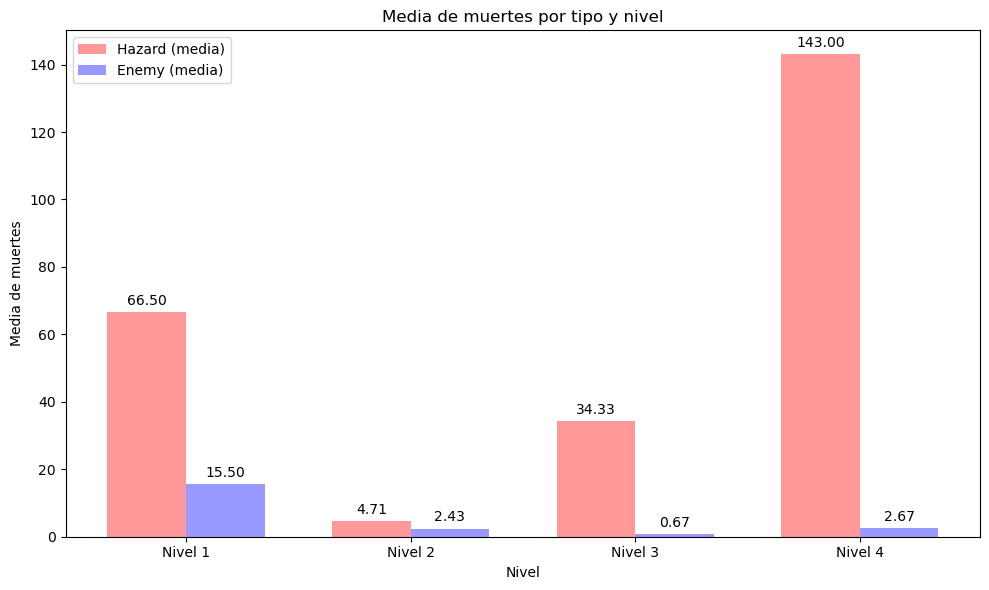

In [15]:
import matplotlib.pyplot as plt
import numpy as np

media_hazard = []
media_enemy = []
niveles = sorted(conteo_por_nivel.keys())

for nivel_id in niveles:
    muertes = muertes_por_nivel.get(nivel_id, [])
    
    # Contar muertes por tipo
    hazard_count = sum(1 for d in muertes if d.get("dt", 0) == 0)
    enemy_count = sum(1 for d in muertes if d.get("dt", 0) == 1)
    
    apariciones = conteo_por_nivel[nivel_id]
    
    media_hazard.append(hazard_count / apariciones if apariciones > 0 else 0)
    media_enemy.append(enemy_count / apariciones if apariciones > 0 else 0)

niveles_labels = [f"Nivel {n}" for n in niveles]
x = np.arange(len(niveles_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, media_hazard, width, label='Hazard (media)', color="#FF9999")
bar2 = ax.bar(x + width/2, media_enemy, width, label='Enemy (media)', color="#9999FF")

ax.set_xlabel("Nivel")
ax.set_ylabel("Media de muertes")
ax.set_title("Media de muertes por tipo y nivel")
ax.set_xticks(x)
ax.set_xticklabels(niveles_labels)
ax.legend()

for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.savefig("graphics/media_muertes_por_tipo_y_nivel.png")


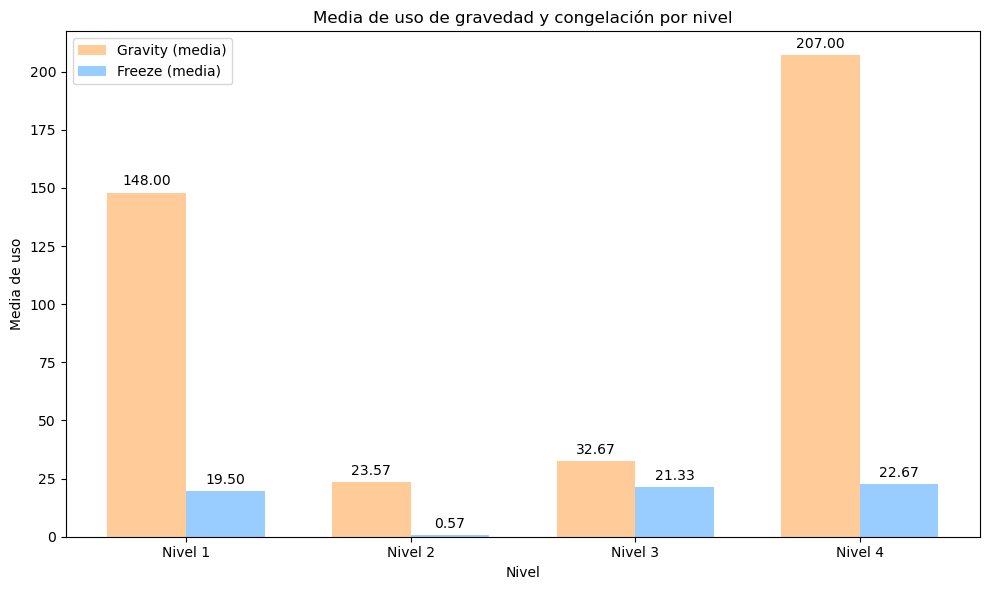

In [16]:
import matplotlib.pyplot as plt
import numpy as np

niveles = sorted(conteo_por_nivel.keys())
media_gravity = []
media_freeze = []

for nivel_id in niveles:
    gravity_count = len(gravity_por_nivel.get(nivel_id, []))
    freeze_count = len(freeze_por_nivel.get(nivel_id, []))
    apariciones = conteo_por_nivel[nivel_id]
    
    media_gravity.append(gravity_count / apariciones if apariciones > 0 else 0)
    media_freeze.append(freeze_count / apariciones if apariciones > 0 else 0)

niveles_labels = [f"Nivel {n}" for n in niveles]
x = np.arange(len(niveles_labels))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(x - width/2, media_gravity, width, label='Gravity (media)', color="#FFCC99")
bar2 = ax.bar(x + width/2, media_freeze, width, label='Freeze (media)', color="#99CCFF")

ax.set_xlabel("Nivel")
ax.set_ylabel("Media de uso")
ax.set_title("Media de uso de gravedad y congelación por nivel")
ax.set_xticks(x)
ax.set_xticklabels(niveles_labels)
ax.legend()

for bars in [bar1, bar2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.savefig("graphics/media_uso_gravedad_y_freeze_por_nivel.png")


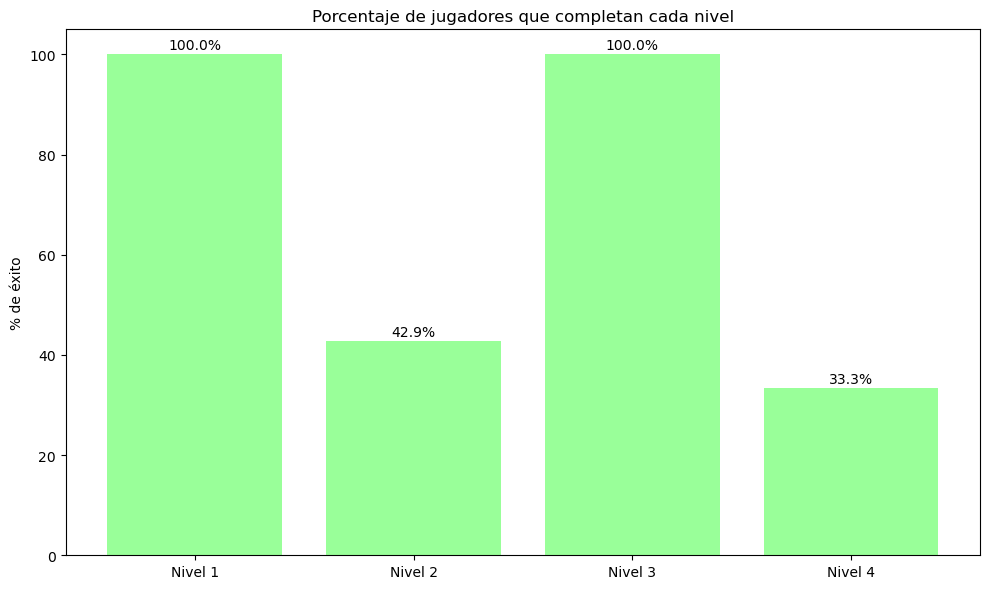

In [17]:
from collections import defaultdict
import matplotlib.pyplot as plt
import numpy as np

# Conteo de éxitos y total por nivel
nivel_intentos = defaultdict(int)
nivel_exitos = defaultdict(int)

for nivel in all_levels:
    nivel_id = nivel["levelid"]
    resultado = nivel.get("result", 0)  # result es un entero: 1=éxito, 0=fallo
    nivel_intentos[nivel_id] += 1
    if resultado == 1:
        nivel_exitos[nivel_id] += 1

# Cálculo de porcentaje
niveles = sorted(nivel_intentos.keys())
porcentaje_exito = [
    (nivel_exitos[n] / nivel_intentos[n]) * 100 if nivel_intentos[n] > 0 else 0
    for n in niveles
]

# Gráfico
x = np.arange(len(niveles))
labels = [f"Nivel {n}" for n in niveles]

plt.figure(figsize=(10, 6))
plt.bar(x, porcentaje_exito, color="#99FF99")
plt.xticks(x, labels)
plt.ylabel("% de éxito")
plt.title("Porcentaje de jugadores que completan cada nivel")
plt.ylim(0, 105)

# Etiquetas sobre las barras
for i, val in enumerate(porcentaje_exito):
    plt.text(i, val + 1, f"{val:.1f}%", ha='center')

plt.tight_layout()
plt.savefig("graphics/porcentaje_exito_por_nivel.png")


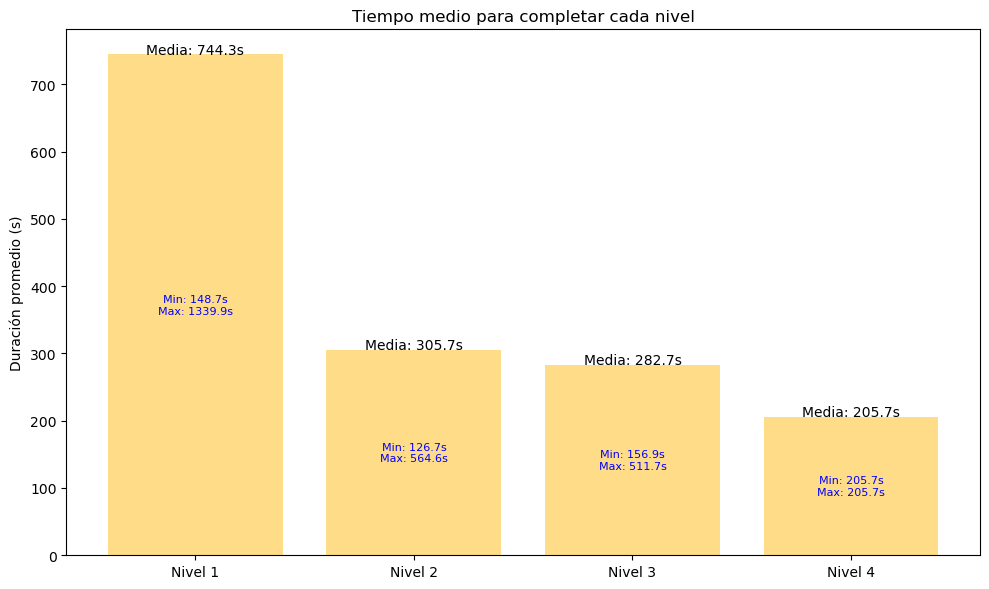

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

nivel_duraciones = defaultdict(list)

for nivel in all_levels:
    nivel_id = nivel["levelid"]
    duracion = nivel.get("duration")
    resultado = nivel.get("result")

    if duracion is not None and resultado == 1:  # Solo niveles completados
        nivel_duraciones[nivel_id].append(duracion / 1000)  # duración en segundos

niveles = sorted(nivel_duraciones.keys())
duracion_promedio = [np.mean(nivel_duraciones[n]) if nivel_duraciones[n] else 0 for n in niveles]
duracion_minima = [np.min(nivel_duraciones[n]) if nivel_duraciones[n] else 0 for n in niveles]
duracion_maxima = [np.max(nivel_duraciones[n]) if nivel_duraciones[n] else 0 for n in niveles]

x = np.arange(len(niveles))
labels = [f"Nivel {n}" for n in niveles]

plt.figure(figsize=(10, 6))
bars = plt.bar(x, duracion_promedio, color="#FFDD88")
plt.xticks(x, labels)
plt.ylabel("Duración promedio (s)")
plt.title("Tiempo medio para completar cada nivel")

# Añadir anotaciones
for i, bar in enumerate(bars):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 1, f"Media: {height:.1f}s", ha='center', fontsize=10)
    plt.text(bar.get_x() + bar.get_width()/2, height/2,
             f"Min: {duracion_minima[i]:.1f}s\nMax: {duracion_maxima[i]:.1f}s",
             ha='center', va='center', fontsize=8, color='blue')

plt.tight_layout()
plt.savefig("graphics/duracion_promedio_por_nivel.png")


In [19]:
from collections import defaultdict

gravity_muertes = defaultdict(lambda: {"totales": 0, "por_mecanica": 0})
freeze_muertes = defaultdict(lambda: {"totales": 0, "por_mecanica": 0})

for nivel in all_levels:
    nivel_id = nivel["levelid"]
    deaths = nivel.get("deaths", [])
    gravity = nivel.get("gravity", [])
    freeze = nivel.get("freeze", [])

    # Cada muerte es un dict con timestamp: añadimos si no está
    for death in deaths:
        ts_death = death.get("timestamp")  # asegúrate de tener esto en tus eventos

        # Contar total
        gravity_muertes[nivel_id]["totales"] += 1
        freeze_muertes[nivel_id]["totales"] += 1

        # --- GRAVITY: muerte en 500 ms después de un cambio de gravedad ---
        for g in gravity:
            ts_gravity = g.get("timestamp")
            if ts_gravity is not None and ts_death is not None:
                if 0 < ts_death - ts_gravity <= 500:
                    gravity_muertes[nivel_id]["por_mecanica"] += 1
                    break  # Solo contamos una vez

        # --- FREEZE: muerte entre start y end de freeze ---
        for f in freeze:
            ts_freeze_start = f.get("timestamp")  # debes guardarlo al construir `freeze`
            ts_freeze_end = ts_freeze_start + f["duration"] if ts_freeze_start else None
            if ts_freeze_start and ts_freeze_end and ts_death:
                if ts_freeze_start < ts_death < ts_freeze_end:
                    freeze_muertes[nivel_id]["por_mecanica"] += 1
                    break


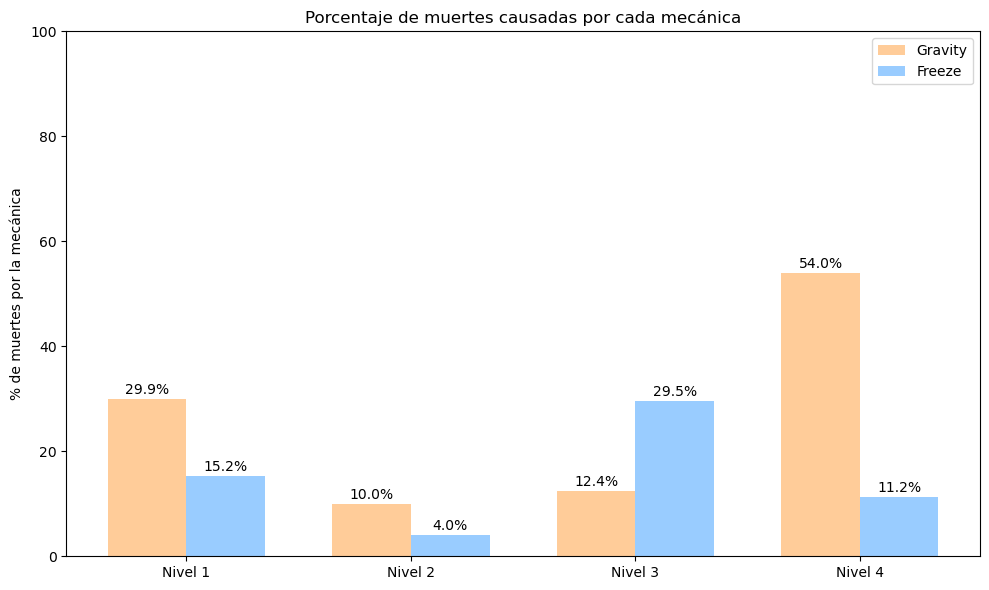

In [20]:
import matplotlib.pyplot as plt
import numpy as np

niveles = sorted(set(gravity_muertes.keys()) | set(freeze_muertes.keys()))

gravity_pct = []
freeze_pct = []
labels = []

for n in niveles:
    labels.append(f"Nivel {n}")
    g = gravity_muertes[n]
    f = freeze_muertes[n]
    g_p = (g["por_mecanica"] / g["totales"] * 100) if g["totales"] > 0 else 0
    f_p = (f["por_mecanica"] / f["totales"] * 100) if f["totales"] > 0 else 0
    gravity_pct.append(g_p)
    freeze_pct.append(f_p)

x = np.arange(len(niveles))
width = 0.35

plt.figure(figsize=(10, 6))
plt.bar(x - width/2, gravity_pct, width, label="Gravity", color="#FFCC99")
plt.bar(x + width/2, freeze_pct, width, label="Freeze", color="#99CCFF")

plt.xticks(x, labels)
plt.ylabel("% de muertes por la mecánica")
plt.title("Porcentaje de muertes causadas por cada mecánica")
plt.ylim(0, 100)
plt.legend()

# Etiquetas sobre barras
for i, (g, f) in enumerate(zip(gravity_pct, freeze_pct)):
    plt.text(i - width/2, g + 1, f"{g:.1f}%", ha='center')
    plt.text(i + width/2, f + 1, f"{f:.1f}%", ha='center')

plt.tight_layout()
plt.savefig("graphics/porcentaje_muertes_por_mecanica.png")


# Análisis de los datos

# 1. Porcentaje de éxito por nivel

![Grafica porcentaje de exito](graphics/porcentaje_exito_por_nivel.png)

## Descripción:

Esta gráfica muestra el porcentaje de jugadores que completaron con éxito cada nivel.

## Interpretación:

Niveles con bajo porcentaje podrían ser demasiado difíciles o confusos.

Niveles con alto porcentaje indican que los jugadores no encontraron grandes obstáculos.

# 2. Duración media por nivel

![Grafica duracion media](graphics/duracion_promedio_por_nivel.png)

## Descripción:

Duración promedio (en segundos) que los jugadores tardan en completar cada nivel.

## Interpretación:

Una duración más alta puede indicar un diseño más complejo o confuso.

La diferencia entre el tiempo mínimo y máximo muestra la variabilidad en la experiencia de los jugadores:

Un rango amplio puede indicar que algunos jugadores terminan rápido mientras otros se quedan atascados o exploran.

Un rango estrecho puede indicar una experiencia más uniforme.

# 3. Muertes por tipo y nivel

![Grafica media muertes](graphics/media_muertes_por_tipo_y_nivel.png)

## Descripción:

Esta gráfica muestra el número medio de muertes por tipo (hazard o enemy) en cada nivel.

## Interpretación:

Una mayor cantidad de muertes por hazard (trampas del entorno) puede indicar que el diseño del nivel es confuso o poco intuitivo.

Una mayor cantidad de muertes por enemy (enemigos) puede reflejar desafíos de combate o colocación agresiva de enemigos.

Es útil cruzar esta información con el porcentaje de éxito para ver si los picos de dificultad afectan la tasa de superación del nivel.

# 4. Uso de mecánicas por nivel: gravity y freeze

![Grafica media mecanicas](graphics/media_uso_gravedad_y_freeze_por_nivel.png)

## Descripción:

Media de veces que los jugadores usaron las mecánicas Gravity y Freeze en cada nivel.

## Interpretación:

Refleja cuán presente y necesaria es cada mecánica en los niveles.

Puede ayudar a detectar si hay mecánicas infrautilizadas o sobreexplotadas.

# 5. Porcentaje de muertes por mecánica

![Grafica media mecanicas](graphics/porcentaje_muertes_por_mecanica.png)

## Descripción:

Muestra qué porcentaje de muertes está directamente relacionado con el mal uso de una mecánica (Gravity o Freeze).

## Criterios usados:

Se considera una muerte causada por Gravity si ocurre en los 0.5s posteriores a un cambio de gravedad.

Se considera una muerte causada por Freeze si ocurre entre el inicio (FreezeStart) y fin (FreezeEnd) de la congelación.

## Interpretación:

Altos porcentajes pueden indicar una curva de aprendizaje mal calibrada o un diseño punitivo.

También puede señalar necesidad de mejorar la introducción o feedback visual de las mecánicas.

# 6. Mapas de calor de muertes por nivel

## Descripción:

Esta sección presenta un mapa de calor por nivel que visualiza las zonas del mapa donde los jugadores mueren con más frecuencia. Cada imagen representa un nivel distinto.

## Interpretación:

Las zonas más calientes (colores más intensos) indican áreas con mayor concentración de muertes.

Identifica puntos conflictivos, posibles bugs de diseño o trampas inesperadas.

Útil para ajustar la dificultad o rediseñar partes del nivel que no funcionan como se esperaba.

#### Nivel 1
![Mapa de calor Nivel 1](graphics/nivel1_deaths_heatmap.png)

#### Nivel 2
![Mapa de calor Nivel 2](graphics/nivel2_deaths_heatmap.png)

#### Nivel 3
![Mapa de calor Nivel 3](graphics/nivel3_deaths_heatmap.png)

#### Nivel 4
![Mapa de calor Nivel 4](graphics/nivel4_deaths_heatmap.png)